In [1]:
import itk

from distutils.version import StrictVersion as VS
if VS(itk.Version.GetITKVersion()) < VS("4.9.0"):
    print("ITK 4.9.0 is required.")
    sys.exit(1)
    

In [2]:
itk.Version.GetITKVersion()

'4.13.0'

In [3]:
fixedImageFile  =  "/tmp/fixed.dcm"
movingImageFile =  "/tmp/moving.dcm"
outputImageFile =  "/tmp/output.png"
differenceImageAfterFile = "/tmp/differenceAfter.png"
differenceImageBeforeFile = "/tmp/differenceBefore.png"

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pydicom

In [5]:
PixelType = itk.ctype('float')

Dimension = 2
ImageType = itk.Image[PixelType, Dimension]

fixed_reader = itk.ImageFileReader[ImageType].New()
fixed_reader.SetFileName(fixedImageFile)
moving_reader = itk.ImageFileReader[ImageType].New()
moving_reader.SetFileName(movingImageFile)




In [6]:
fixed_reader.Update()
moving_reader.Update()

Dimension = fixed_reader.GetOutput().GetImageDimension()
FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]

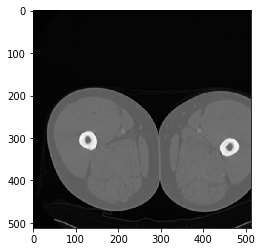

In [7]:
plt.imshow(itk.GetArrayFromImage(fixed_reader.GetOutput()), interpolation='nearest',cmap='gray')
plt.show()

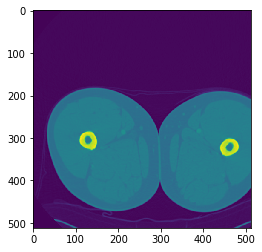

In [8]:
plt.imshow(itk.GetArrayFromImage(moving_reader.GetOutput()), interpolation='nearest')
plt.show()

In [9]:
TransformType = itk.Rigid2DTransform#[itk.D, Dimension]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200)

In [10]:
#metric = itk.MeanSquaresImageToImageMetricv4[
#    FixedImageType, MovingImageType].New()
metric = itk.JointHistogramMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()




In [11]:
aaa= itk.GetArrayFromImage(fixed_reader.GetOutput())

In [12]:
registration = itk.ImageRegistrationMethodv4.New()

In [13]:
registration.SetFixedImage(fixed_reader.GetOutput())
registration.SetMovingImage(moving_reader.GetOutput())

In [14]:
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.SetInitialTransform(initialTransform)

In [15]:
movingInitialTransform = TransformType.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
movingInitialTransform.SetParameters(initialParameters)
registration.SetMovingInitialTransform(movingInitialTransform)

In [16]:
identityTransform = TransformType.New()
identityTransform.SetIdentity()
registration.SetFixedInitialTransform(identityTransform)

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])

In [17]:
registration.Update()

In [18]:
transform = registration.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)

numberOfIterations = optimizer.GetCurrentIteration()

bestValue = optimizer.GetValue()

In [19]:
print("Result = ")
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))


Result = 
 Translation X = -2.9999421996986086
 Translation Y = -0.022799104213093856
 Iterations    = 4
 Metric value  = 1.7976931348623157e+308


In [20]:
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

In [21]:
resampler = itk.ResampleImageFilter.New(Input=moving_reader.GetOutput(),
        Transform=outputCompositeTransform,
        UseReferenceImage=True,
        ReferenceImage=fixed_reader.GetOutput())
resampler.SetDefaultPixelValue(100)


In [22]:
OutputPixelType = itk.ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, Dimension]

caster = itk.CastImageFilter[FixedImageType,
        OutputImageType].New(Input=resampler)

writer = itk.ImageFileWriter.New(Input=caster, FileName=outputImageFile)
writer.SetFileName(outputImageFile)
writer.Update()

In [23]:
difference = itk.SubtractImageFilter.New(Input1=fixed_reader.GetOutput(),
        Input2=resampler)

intensityRescaler = itk.RescaleIntensityImageFilter[FixedImageType,
        OutputImageType].New(
            Input=difference,
            OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
            OutputMaximum=itk.NumericTraits[OutputPixelType].max())

In [24]:
resampler.SetDefaultPixelValue(1)
writer.SetInput(intensityRescaler.GetOutput())
writer.SetFileName(differenceImageAfterFile)
writer.Update()

resampler.SetTransform(identityTransform)
writer.SetFileName(differenceImageBeforeFile)
writer.Update()